## Aplicação do PageRank em nosso conjunto de dados

Como visto anteriormente, nosso conjunto de dados relaciona 7060 sites. Portanto, seguiremos com a aplicação dos algorítmos.

Para isso, precisaremos dos seguintes módulos.

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Recuperando e visualizando os dados

Vamos, portanto, adquirir a _array_ do `numpy` e o _dataframe_ do `pandas`.

In [2]:
L = np.load('datasets/wiki_db.npz')['arr_0']
df = pd.read_csv('datasets/wikipedia.gzip', compression='gzip')

Agora podemos, com auxílio dos pacotes `networkx` e `matplotlib`, visualizar em forma de grafos nosso _dataset_.
Para isso, criamos o objeto grafo a partir de nossa matriz.

In [3]:
%%time
G = nx.from_numpy_array(L)

CPU times: user 1.45 s, sys: 43.9 ms, total: 1.5 s
Wall time: 1.49 s


Veja abaixo como estão as relações dos grafos. Decidimos por retirar os nós e reduzir a opacidade das linhas para ter-se melhor entendimento. Pode-se ver que, muito possivelmente devido aos assuntos serem próximos e/ou páginas de auxílio da Wikipédia, há uma grande concentração de conexões em comum. Embora haja uma quantidade razoável de nós fora desse núcleo.

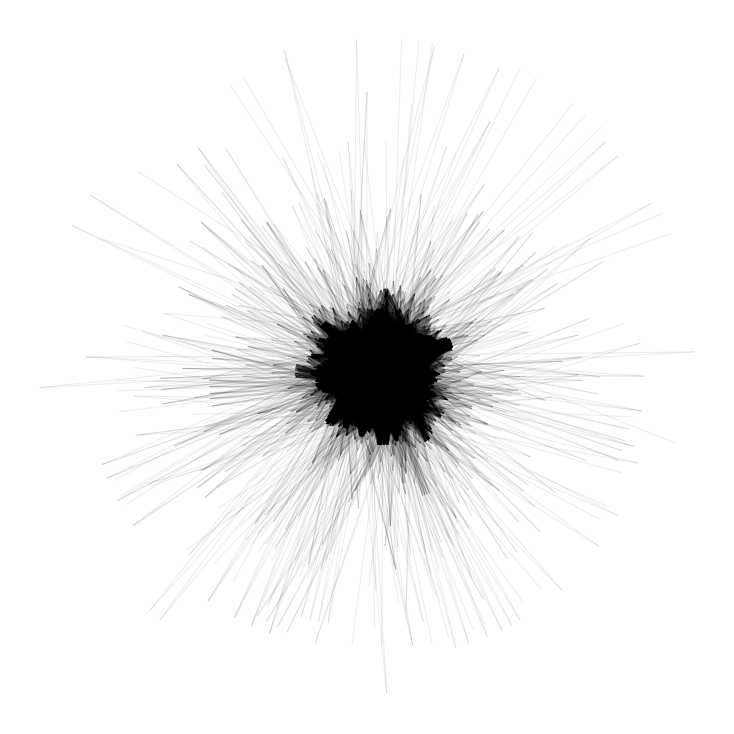

In [12]:
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=False, node_size=0, alpha=0.08)

In [13]:
########## PARA APAGAR ############
def dotPageRank(linkMatrix, d) :
    n = linkMatrix.shape[0]
    M = d * linkMatrix + (1-d)/n * np.ones([n, n])
    r = 100 * np.ones(n) / n # Vetor (n linhas 1/n × 100 cada)
    last = r
    r = M @ r
    while la.norm(last - r) > 0.01 :
        last = r
        r = M @ r
    return r
def eigPageRank(linkMatrix):
    eVals, eVecs = la.eig(L) # Calcula os autovalores e autovetores
    order = np.absolute(eVals).argsort()[::-1] # Ordena pelos autovetores
    eVals = eVals[order]
    eVecs = eVecs[:,order]

    r = eVecs[:, 0] # r é o principal autovetor
    return 100 * np.real(r / np.sum(r)) # Faz o vetor somar um (e multiplica por 100).

### Aplicando os algorítmos

Vamos utilizar ambos os algorítmos apresentados em seções anteriores e depois relacioná-los com o _dataframe_. 

Primeiramente, utilizando o método dos autovetores.

In [14]:
%%time
eigPR = eigPageRank(L)

CPU times: user 4min 35s, sys: 1min 13s, total: 5min 48s
Wall time: 1min 8s


Em seguida, o método do _dot-product_.

In [15]:
%%time
dotPR = dotPageRank(L, 1) # Utilizando 1 para fazer uma comparação justa.

CPU times: user 1.17 s, sys: 332 ms, total: 1.51 s
Wall time: 679 ms


Observe-os

In [16]:
eigPR

array([5.51433066e-01, 2.52080379e-02, 8.63712287e-02, ...,
       1.34295455e-06, 4.37247323e-07, 4.37247323e-07])

In [17]:
dotPR

array([3.14136484e-03, 1.43603365e-04, 4.92033500e-04, ...,
       7.65044842e-09, 2.49087959e-09, 2.49087959e-09])

Os valores são, de fato, bem diferentes. Mas vamos ver quais páginas eles apontam como mais bem ranqueadas.

Vamos, para cada um dos resultados, criar um _dataframe_ que une o resultado com os sites.

In [22]:
# Removendo a coluna link do df
df2 = df.drop(columns = ['link'])
# Adquirindo os sites
cols = list(df2.columns)

In [23]:
# Método dos autovetores
rel_eig = pd.DataFrame(eigPR, cols)

In [24]:
# Método do dotproduct
rel_dot = pd.DataFrame(dotPR, cols)

Agora podemos visualizar os primeiros 15 resultados de cada um dos _dataframes_ ordenados.

In [25]:
# Método dos autovetores
rel_eig.sort_values(0, ascending=False)[0:15]

,0
./Especial:Fontes_de_livros/978-0-07-709840-7,1.998577
./Emil_Artin,1.800438
./Universidade_de_Poitiers,1.495650
./Árvore_(grafo),1.212889
./Special:BookSources/8573930217,1.044034
./Dualidade,0.878467
./Wikimedia,0.712887
./Conexidade,0.706123
./Função_de_Heaviside,0.669221
./Função_côncava,0.657430


In [26]:
# Método do dotproduct
rel_dot.sort_values(0, ascending=False)[0:15]

,0
./Especial:Fontes_de_livros/978-0-07-709840-7,0.011385
./Emil_Artin,0.010257
./Universidade_de_Poitiers,0.008520
./Árvore_(grafo),0.006910
./Special:BookSources/8573930217,0.005948
./Dualidade,0.005004
./Wikimedia,0.004061
./Conexidade,0.004023
./Função_de_Heaviside,0.003812
./Função_côncava,0.003745


Como pode-se ver, há os mesmos resultados em ambos. Agora vamos visualizar até que ponto eles se mantém iguais.

In [57]:
# Valores ranqueados do método dos autovalores
top_eig = rel_eig.sort_values(0, ascending=False).index
# Valores ranqueados do método do dotproduct
top_dot = rel_dot.sort_values(0, ascending=False).index
# Lista com as posições dos erros
errors = []
# Posição inicial pra ser iterada
pos = 0
for eig, dot in zip(top_eig, top_dot):
    if eig == dot:
        pos +=1
        continue
    else:
        pos +=1
        errors.append(pos)

Agora vemos as informações sobre esses erros.

In [60]:
info = f"""
Quantidade: {len(errors)}
Menor Posição: {errors[0]}
Maior Posição: {errors[-1]}
"""
print(info)


Quantidade: 1610
Menor Posição: 680
Maior Posição: 7059



Vendo as informações antigas, podemos ver que, para o erro menor que 0.01 arbitrário que colocamos na função, conseguimos igualdade nos primeiros 680 resultados. De certo modo, é absurdamente raro alguém alcançar essa página ao fazer uma busca. Portanto, é um resultado muito satisfatório, principalmente ao comparar 679 ms com 1min 8s.

Evidentemente, é muito melhor ter uma busca extremamente rápida que atende a imensa maioria das buscas perfeitamente que ter uma busca extremamente demorada que mal aumenta a qualidade da busca.

Além do mais, outro fator importante que, entre a posição 680 e a posição 7059 (a última), há somente 1610 discrepâncias. Ou seja, dentre os últimos 6379 sites, há 25% de variação na posição. O que não é necessáriamente ruim.

Por fim, também é possivel diminuir ainda mais o erro permitido sem comprometer tanto a velocidade da busca.

### Adicionando fator de aleatoriedade

Como vimos que o método do _dotproduct_ é eficiente, podemos utilizá-lo com o parâmetro de aleatoriedade. O que siginifca que assumimos que um usuário pode simplesmente escolher uma outra página do nosso universo e acessá-la pelo campo de url.

In [61]:
%%time
rdotPR = dotPageRank(L, .8) # Adicionando 20% de chance dele acessar um outro site.

CPU times: user 1.28 s, sys: 292 ms, total: 1.57 s
Wall time: 676 ms


Os valores aparentam ter se alterado, observe.

In [62]:
rdotPR

array([4.45748404e-03, 2.71656386e-04, 6.18290061e-04, ...,
       3.77894048e-05, 3.78760848e-05, 3.78760848e-05])

Mas para saber a verdade, teremos que criar um _dataset_ a relacionando com os links.

In [64]:
rel_rdot = pd.DataFrame(rdotPR, cols)

Já podemos ver que, de fato, já há algumas alterações nas posições.

In [65]:
rel_rdot.sort_values(0, ascending=False)[0:15]

,0
./Especial:Fontes_de_livros/978-0-07-709840-7,0.016114
./Emil_Artin,0.013855
./Universidade_de_Poitiers,0.011555
./Árvore_(grafo),0.009739
./Special:BookSources/8573930217,0.008365
./Dualidade,0.007140
./Conexidade,0.006100
./Wikimedia,0.005415
./Função_de_Heaviside,0.005171
./Função_côncava,0.005058


Agora, usaremos da mesma lógica aplicada entre os dois métodos para verificar as discrepâncias.

In [66]:
# Valores ranqueados do método do dotproduct sem aleatoriedade
top_dot = rel_dot.sort_values(0, ascending=False).index
# Valores ranqueados do método do dotproduct com aleatoriedade
top_rdot = rel_rdot.sort_values(0, ascending=False).index
# Lista com as posições das diferenças
diff = []
# Posição inicial pra ser iterada
idx = 0
for eig, dot in zip(top_dot, top_rdot):
    if eig == dot:
        idx +=1
        continue
    else:
        idx +=1
        diff.append(idx)

In [67]:
info = f"""
Quantidade: {len(diff)}
Menor Posição: {diff[0]}
Maior Posição: {diff[-1]}
"""
print(info)


Quantidade: 7018
Menor Posição: 7
Maior Posição: 7060



Como se pode ver, há uma variação enorme entre os dois. É importante esclarecer que nesse caso não se tratam de erros, pois o método utilizado adota essa aleatoriedade como verdade.

Para os mecanismos de busca, possivelmente adotar uma porcentagem de aleatoriedade seja extremamente relevante, mas 20% aparenta ser um exagero.